
📊 Logistic Regression Accuracy: 0.9344
               precision    recall  f1-score   support

         Fair       0.94      0.94      0.94       250
      Günstig       0.92      0.97      0.94       217
Scam-Verdacht       0.96      0.83      0.89        52
     Zu teuer       0.94      0.90      0.92        91

     accuracy                           0.93       610
    macro avg       0.94      0.91      0.92       610
 weighted avg       0.94      0.93      0.93       610



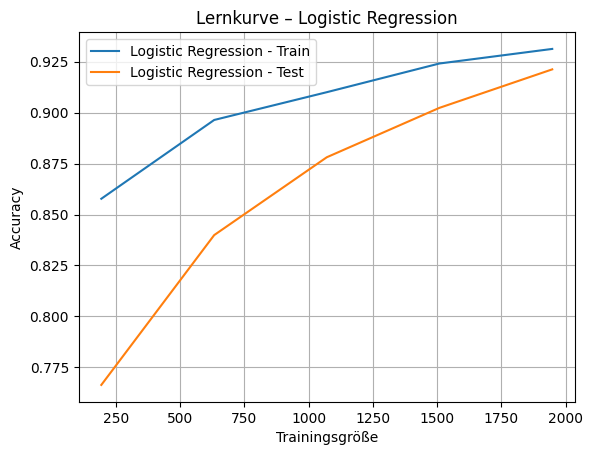


📊 Random Forest Accuracy: 0.8934
               precision    recall  f1-score   support

         Fair       0.86      0.94      0.90       250
      Günstig       0.91      0.90      0.90       217
Scam-Verdacht       0.93      0.83      0.88        52
     Zu teuer       0.95      0.78      0.86        91

     accuracy                           0.89       610
    macro avg       0.91      0.86      0.88       610
 weighted avg       0.90      0.89      0.89       610



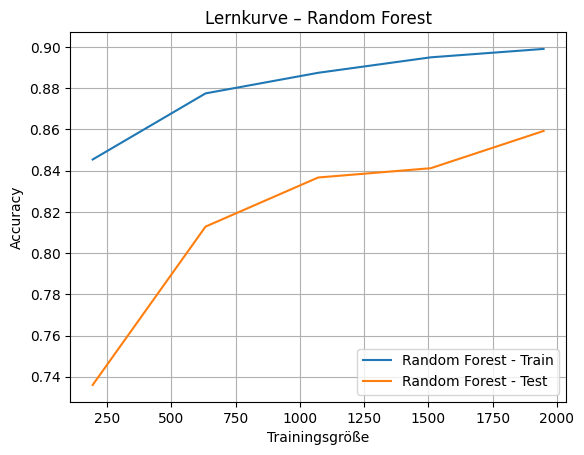


📊 Gradient Boosting Accuracy: 0.9607
               precision    recall  f1-score   support

         Fair       0.96      0.96      0.96       250
      Günstig       0.97      0.95      0.96       217
Scam-Verdacht       0.93      0.96      0.94        52
     Zu teuer       0.96      0.97      0.96        91

     accuracy                           0.96       610
    macro avg       0.95      0.96      0.96       610
 weighted avg       0.96      0.96      0.96       610



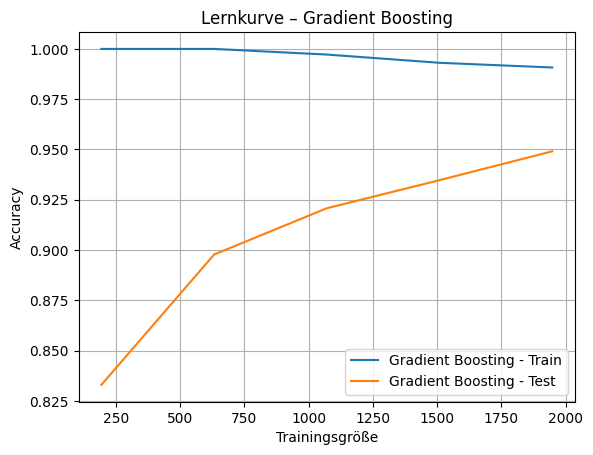


✅ Bestes Modell: Gradient Boosting mit Accuracy 0.9607 gespeichert.


In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump
import json

# 1. CSV laden
df = pd.read_csv("../data/immowelt_daten_clean.csv")

# 2. Features und Zielvariable auswählen
X = df[["Preis pro qm in euro", "Wohnfläche", "Zimmer", "Ausstattungsgrad_gruppe", "Bezirk"]]
y = df["Fairness_Label"]

# 3. One-Hot-Encoding für den Bezirk
X = pd.get_dummies(X, columns=["Bezirk"])

# 4. Numerische Features skalieren
numerische_features = ["Preis pro qm in euro", "Wohnfläche", "Zimmer", "Ausstattungsgrad_gruppe"]
scaler = StandardScaler()
X[numerische_features] = scaler.fit_transform(X[numerische_features])

# 5. Zielvariable label-encoden
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 6. Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 7. Modelle definieren
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        C=1.0,             # Regularisierung (kleiner = stärker)
        penalty="l2",      # Standard, aber explizit
        solver="lbfgs"     # gut für kleinere Datensätze
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,             # Tiefe der Bäume begrenzen
        min_samples_leaf=5,       # Jeder Blattknoten muss mind. 5 Samples enthalten
        max_features="sqrt",      # Weniger Features je Split → reduziert Overfitting
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,         # kleiner Wert = langsamer, aber stabiler Lernprozess
        max_depth=3,               # Bäume flacher halten (Standard ist 3 – gut für Boosting)
        min_samples_leaf=5,        # verhindert zu starkes Anpassen an kleine Gruppen
        subsample=0.8,             # 80% der Daten pro Baum → wie bei Random Forest etwas zufällig
        random_state=42
    )
}

best_model = None
best_score = 0
results = {}

# 8. Modelle trainieren, testen und Lernkurven plotten
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, label=f"{name} - Train")
    plt.plot(train_sizes, test_mean, label=f"{name} - Test")
    plt.xlabel("Trainingsgröße")
    plt.ylabel("Accuracy")
    plt.title(f"Lernkurve – {name}")
    plt.legend()
    plt.grid()
    plt.show()

    if acc > best_score:
        best_score = acc
        best_model = model
        best_model_name = name


# 9. Modell speichern
# Modellordner anlegen, falls nicht vorhanden
os.makedirs("../model", exist_ok=True)

# Modell speichern
dump(best_model, "../model/bestes_fairness_model.joblib")
dump(scaler, "../model/scaler.joblib")
dump(encoder, "../model/label_encoder.joblib")

# Feature-Spalten speichern
feature_columns = X.columns.tolist()
with open("../model/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

print(f"\n✅ Bestes Modell: {best_model_name} mit Accuracy {best_score:.4f} gespeichert.")